In [2]:
import numpy as np
import pandas as pd

from collections import defaultdict
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score

# Why the original group fairness didn't work
In this notebook, we run an example of using the original constraint and plotting pareto curves. All code is directly copied from the main notebook, but with the original constraint implemented instead of our modified version.

In [3]:
income = pd.read_csv('../data/income.csv')
income['native-country'] = income['native-country'].apply(lambda x: x if x == 'United-States' else 'Other')
income['target'] = income.income.map({'<=50K': 0, '>50K': 1})

income['gender_group'] = income.gender.map({'Male': 0, 'Female': 1})

In [4]:
nom_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
num_features = ['educational-num']
target = 'target'
groups = 'gender_group'

In [5]:
preprocessing = ColumnTransformer(
    [('onehotencoder', OneHotEncoder(handle_unknown='ignore'), nom_features),
     ('standardscaler', StandardScaler(), num_features)
     ])

In [6]:
def equalized_odds(y_true, y_pred, groups):
    mask = groups == 0
    return y_pred[mask & (y_true == 1)].mean(), y_pred[~mask & (y_true == 1)].mean(), y_pred[mask & (y_true == 0)].mean(), y_pred[~mask & (y_true == 0)].mean()

In [7]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self,
                 in_dim: int):
        super().__init__()
        
        self.linear = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear(x)).flatten()
    
    def fit(self, x, y, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10):
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y in trainloader:
                y_pred = self(x)
                loss = criterion(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


In [8]:
class KfoldTracker:
    def __init__(self):
        self.performance = defaultdict(list)
        self.fairness = defaultdict(list)
        self.feature_importance = defaultdict(list)
        self.group_tracker = defaultdict(KfoldTracker)

    def log_performance(self, y_true, y_pred):
        self.performance['Accuracy'].append(accuracy_score(y_true, y_pred))
        self.performance['Balanced accuracy'].append(balanced_accuracy_score(y_true, y_pred))
        self.performance['f1-score'].append(f1_score(y_true, y_pred))
        self.performance['ROC AUC'].append(roc_auc_score(y_true, y_pred))

    def log_fairness(self, y_true, y_pred, groups):
        tpr_g1, tpr_g2, fpr_g1, fpr_g2 = equalized_odds(y_true, y_pred, groups)
        self.fairness['TPR G1'].append(tpr_g1)
        self.fairness['TPR G2'].append(tpr_g2)
        self.fairness['FPR G1'].append(fpr_g1)
        self.fairness['FPR G2'].append(fpr_g2)

    def log_feature_importance(self, feature_importance, feature_names):
        for i, name in enumerate(feature_names):
            self.feature_importance[name].append(feature_importance[i])
        for key in self.feature_importance.keys():
            if key not in feature_names:
                self.feature_importance[key].append(np.nan)

    def log(self, y_true, y_pred, groups, feature_importance, feature_names):
        self.log_performance(y_true, y_pred)
        self.log_fairness(y_true, y_pred, groups)
        self.log_feature_importance(feature_importance, feature_names)

    def get_mean_performance(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.performance.items()}

    def get_mean_group_performance(self, group_name):
        return {k: (np.mean(v), np.std(v)) for k, v in self.group_performance[group_name].items()}
    
    def get_mean_fairness(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.fairness.items()}
    
    def get_mean_feature_importance(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.feature_importance.items()}

    def __str__(self):
        return str(pd.DataFrame(self.performance).T) + '\n\n' + str(pd.DataFrame(self.fairness).T) + '\n\n' + str(pd.DataFrame(self.feature_importance).T)
    
    def __getitem__(self, key):
        return self.group_tracker[key]

In [9]:
class GroupFairnessConstraint(nn.Module):
    def __init__(self):
        super(GroupFairnessConstraint, self).__init__()
        
    def forward(self, wx, y, groups):
        mask = groups == 0
        S_wx_1, S_y_1 = wx[mask],  y[mask]
        S_wx_2, S_y_2 = wx[~mask], y[~mask]
        
        n_1 = S_wx_1.shape[0]
        n_2 = S_wx_2.shape[0]

        idx1 = torch.arange(n_1)
        idx2 = torch.arange(n_2)

        idx1 = idx1.view(-1, 1)
        idx2 = idx2.view(1, -1)

        idx1 = idx1.repeat(1, idx2.size(1))
        idx2 = idx2.repeat(idx1.size(0), 1)

        result = torch.stack((idx1, idx2), dim=2).view(-1, 2)
        idx1 = result[:, 0]
        idx2 = result[:, 1]
        
        vector = self.d(S_y_1[idx1], S_y_2[idx2]) * (S_wx_1[idx1] - S_wx_2[idx2])
        cost = vector.sum()
        cost = cost / (n_1*n_2)
        cost = cost ** 2

        return cost
        
    def d(self, y_i, y_j):
        return (y_i == y_j).int()
    
class FairBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, in_dim: int, gamma: float = 1e-4):
        super().__init__(in_dim)
        self.gamma = gamma
        self.group_fairness_losses = []
    
    def fit(self, x, y, g, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10, verbose=False):
        criterion = nn.BCELoss()
        fair_criterion = GroupFairnessConstraint()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y, g), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y, g in trainloader:
                y_pred = self(x)
                wx = self.linear(x)
                loss_bce = criterion(y_pred, y)
                loss_fair = self.gamma * fair_criterion(wx, y, g)
                loss = loss_bce + loss_fair

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose:
                    print(f'Epoch: {epoch}, Loss BCE: {round(loss_bce.item(), 4)}, Loss Fair: {round(loss_fair.item(), 4)}')
                    self.group_fairness_losses.append(loss_fair.item())


In [12]:
gammaspace = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
trackers = []

for gamma in gammaspace:
    tracker_fair = KfoldTracker()

    n_splits = 5
    splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(splits.split(income)):
        train = income.iloc[train_idx]
        val = income.iloc[val_idx]
        
        x_train = preprocessing.fit_transform(train).toarray()
        y_train = train[target].values
        g_train = train[groups].values
        
        x_val = preprocessing.transform(val).toarray()
        y_val = val[target].values
        g_val = val[groups].values

        x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

        model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
        model.fit(x_train, y_train, g_train)
        
        y_pred = model(x_val)
        y_pred = y_pred.detach().numpy().round()

        feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
        feature_names = preprocessing.get_feature_names_out()
        tracker_fair.log(y_val, y_pred, g_val, feature_importance, feature_names)

        mask = g_val == 0
        tracker_fair['male'].log_performance(y_val[mask], y_pred[mask])
        tracker_fair['female'].log_performance(y_val[~mask], y_pred[~mask])

    trackers.append(tracker_fair)


Running the above code took 95 minutes

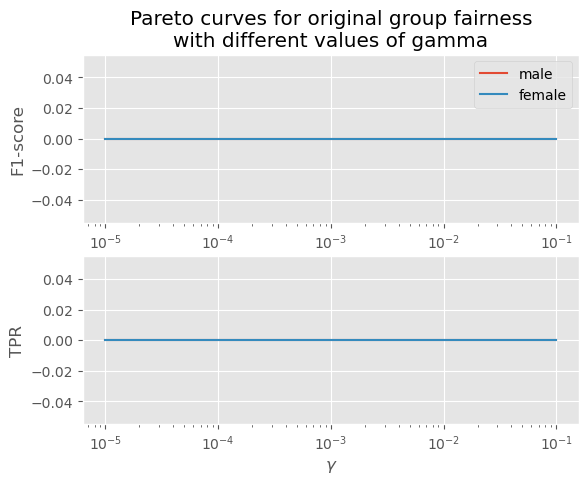

In [18]:
male_perf = np.array([t['male'].get_mean_performance()['f1-score'][0] for t in trackers])
female_perf = np.array([t['female'].get_mean_performance()['f1-score'][0] for t in trackers])

male_unc = np.array([t['male'].get_mean_performance()['f1-score'][1] for t in trackers])
female_unc = np.array([t['female'].get_mean_performance()['f1-score'][1] for t in trackers])

tpr_g1 = np.array([t.get_mean_fairness()['TPR G1'][0] for t in trackers])
tpr_g2 = np.array([t.get_mean_fairness()['TPR G2'][0] for t in trackers])
tpr_g1_unc = np.array([t.get_mean_fairness()['TPR G1'][1] for t in trackers])
tpr_g2_unc = np.array([t.get_mean_fairness()['TPR G2'][1] for t in trackers])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(gammaspace, male_perf, label='male')
ax1.plot(gammaspace, female_perf, label='female')

ax1.fill_between(gammaspace, male_perf + male_unc, male_perf - male_unc, alpha=0.2)
ax1.fill_between(gammaspace, female_perf + female_unc, female_perf - female_unc, alpha=0.2)

ax1.set_xscale('log')

ax1.set_ylabel('F1-score')

ax1.legend()

ax1.set_title('Pareto curves for original group fairness\nwith different values of gamma')

ax2.plot(gammaspace, tpr_g1, label='TPR G1')
ax2.plot(gammaspace, tpr_g2, label='TPR G2')

ax2.fill_between(gammaspace, tpr_g1 + tpr_g1_unc, tpr_g1 - tpr_g1_unc, alpha=0.2)
ax2.fill_between(gammaspace, tpr_g2 + tpr_g2_unc, tpr_g2 - tpr_g2_unc, alpha=0.2)

ax2.set_xscale('log')
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('TPR')

fig.savefig('../reports/figs/original_group_fairness.svg')

Doing another experiment, and this time loggin the fair loss at each call, we can inspect the loss values.

In [22]:
gamma = 1e-3

train = income

x_train = preprocessing.fit_transform(train).toarray()
y_train = train[target].values
g_train = train[groups].values

x_train, y_train, g_train = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train))

model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
model.fit(x_train, y_train, g_train, verbose=True)

C:\Users\marcu\AppData\Local\Temp/ipykernel_9124/3244324858.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))


Epoch: 0, Loss BCE: 0.6261, Loss Fair: 2.159
Epoch: 0, Loss BCE: 0.6326, Loss Fair: 17.1318
Epoch: 0, Loss BCE: 0.6245, Loss Fair: 6.1807
Epoch: 0, Loss BCE: 0.6345, Loss Fair: 0.3652
Epoch: 0, Loss BCE: 0.6436, Loss Fair: 0.2395
Epoch: 0, Loss BCE: 0.6327, Loss Fair: 0.39
Epoch: 0, Loss BCE: 0.6482, Loss Fair: 4.9096
Epoch: 0, Loss BCE: 0.6486, Loss Fair: 0.3409
Epoch: 0, Loss BCE: 0.6565, Loss Fair: 5.876
Epoch: 0, Loss BCE: 0.6468, Loss Fair: 0.1444
Epoch: 0, Loss BCE: 0.6184, Loss Fair: 0.125
Epoch: 0, Loss BCE: 0.637, Loss Fair: 10.6243
Epoch: 0, Loss BCE: 0.6433, Loss Fair: 10.9902
Epoch: 0, Loss BCE: 0.608, Loss Fair: 0.384
Epoch: 0, Loss BCE: 0.6241, Loss Fair: 3.6322
Epoch: 0, Loss BCE: 0.6235, Loss Fair: 7.7214
Epoch: 0, Loss BCE: 0.6211, Loss Fair: 35.6315
Epoch: 0, Loss BCE: 0.5956, Loss Fair: 36.3029
Epoch: 0, Loss BCE: 0.6226, Loss Fair: 0.2735
Epoch: 0, Loss BCE: 0.6151, Loss Fair: 0.1333
Epoch: 0, Loss BCE: 0.6238, Loss Fair: 0.1411
Epoch: 0, Loss BCE: 0.6007, Loss Fair

Visualizing it, we see that the losses are wildly unstable.

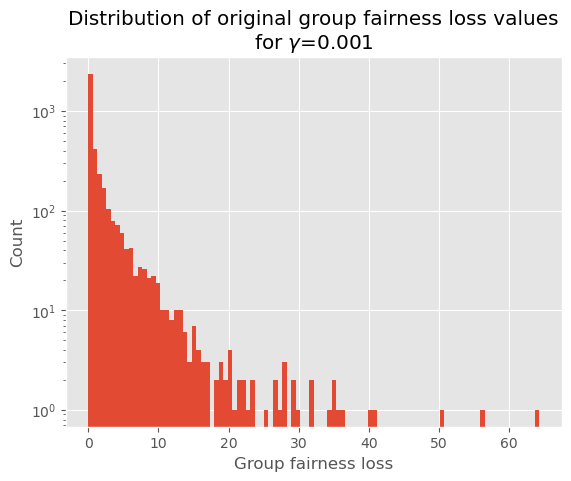

In [30]:
fig, ax = plt.subplots()
ax.hist(model.group_fairness_losses, bins=100)
ax.set_yscale('log')
ax.set_xlabel('Group fairness loss')
ax.set_ylabel('Count')
ax.set_title('Distribution of original group fairness loss values\nfor $\gamma$=0.001')
fig.savefig('../reports/figs/group_fairness_loss_instability.svg')

In [10]:
class GroupFairnessConstraint(nn.Module):
    def __init__(self):
        super(GroupFairnessConstraint, self).__init__()
        
    def forward(self, y_pred, y_true, groups):
        mask = groups == 0
        S_pred_1, S_true_1 = y_pred[mask],  y_true[mask]
        S_pred_2, S_true_2 = y_pred[~mask], y_true[~mask]
        
        n_1 = S_pred_1.shape[0]
        n_2 = S_pred_2.shape[0]

        idx1 = torch.arange(n_1)
        idx2 = torch.arange(n_2)

        idx1 = idx1.view(-1, 1)
        idx2 = idx2.view(1, -1)

        idx1 = idx1.repeat(1, idx2.size(1))
        idx2 = idx2.repeat(idx1.size(0), 1)

        result = torch.stack((idx1, idx2), dim=2).view(-1, 2)
        idx1 = result[:, 0]
        idx2 = result[:, 1]
        
        vector = self.d(S_true_1[idx1], S_true_2[idx2]) * (S_pred_1[idx1] - S_pred_2[idx2])
        cost = vector.sum()
        cost = cost ** 2
        cost = cost / (n_1*n_2)

        return cost
        
    def d(self, y_i, y_j):
        return (y_i == y_j).int()
    
class FairBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, in_dim: int, gamma: float = 1e-4):
        super().__init__(in_dim)
        self.gamma = gamma
        self.group_fairness_losses = []
    
    def fit(self, x, y, g, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10, verbose=False):
        criterion = nn.BCELoss()
        fair_criterion = GroupFairnessConstraint()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y, g), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y, g in trainloader:
                y_pred = self(x)
                loss_bce = criterion(y_pred, y)
                loss_fair = self.gamma * fair_criterion(y_pred, y, g)
                loss = loss_bce + loss_fair

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose:
                    print(f'Epoch: {epoch}, Loss BCE: {round(loss_bce.item(), 4)}, Loss Fair: {round(loss_fair.item(), 4)}')
                    self.group_fairness_losses.append(loss_fair.item())


In [12]:
gamma = 1e-3

train = income

x_train = preprocessing.fit_transform(train).toarray()
y_train = train[target].values
g_train = train[groups].values

x_train, y_train, g_train = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train))

model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
model.fit(x_train, y_train, g_train, verbose=True)

Epoch: 0, Loss BCE: 0.7173, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.6929, Loss Fair: 0.0001
Epoch: 0, Loss BCE: 0.6705, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.6455, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.657, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.6336, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.6154, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.6202, Loss Fair: 0.0001
Epoch: 0, Loss BCE: 0.592, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.5732, Loss Fair: 0.0
Epoch: 0, Loss BCE: 0.5798, Loss Fair: 0.0006
Epoch: 0, Loss BCE: 0.5787, Loss Fair: 0.0002
Epoch: 0, Loss BCE: 0.5591, Loss Fair: 0.0011
Epoch: 0, Loss BCE: 0.557, Loss Fair: 0.0007
Epoch: 0, Loss BCE: 0.5016, Loss Fair: 0.0015
Epoch: 0, Loss BCE: 0.5191, Loss Fair: 0.0009
Epoch: 0, Loss BCE: 0.5104, Loss Fair: 0.0018
Epoch: 0, Loss BCE: 0.5068, Loss Fair: 0.0004
Epoch: 0, Loss BCE: 0.4971, Loss Fair: 0.0008
Epoch: 0, Loss BCE: 0.5406, Loss Fair: 0.0004
Epoch: 0, Loss BCE: 0.4289, Loss Fair: 0.0012
Epoch: 0, Loss BCE: 0.5265, Loss Fair: 0.001
Epoch: 0, Loss B

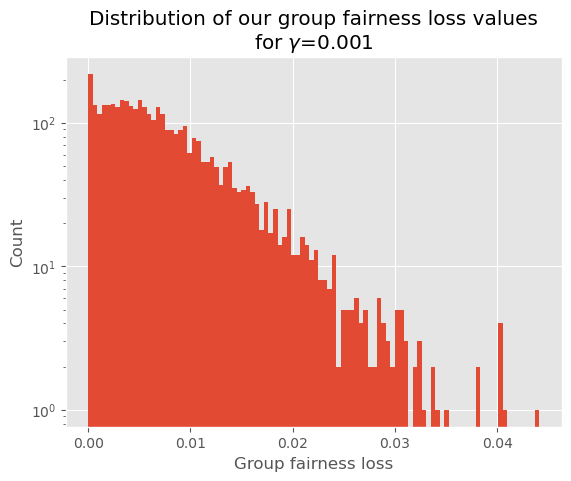

In [13]:
fig, ax = plt.subplots()
ax.hist(model.group_fairness_losses, bins=100)
ax.set_yscale('log')
ax.set_xlabel('Group fairness loss')
ax.set_ylabel('Count')
ax.set_title('Distribution of our group fairness loss values\nfor $\gamma$=0.001')
fig.savefig('../reports/figs/group_fairness_loss_stability.svg')